In [10]:
building_id = 2
price = 400
iteration = 8
# we are ready to run!

In [11]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [12]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_proc = ga_output_dir + "panel_{}_sing_processed.xlsx".format(price)

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [15]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

## the North Axis
The north axis gets grabbed automatically from the idf.

In [16]:
pvbuilding.North_Axis

0.0

In [17]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [18]:
# Determine the hourly electricity use
pvbuilding.run_ep()

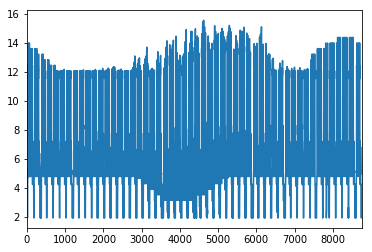

In [19]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [20]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.352204365209053


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [21]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [22]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

In [35]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(180,35,0.2,force_recalc=True)
type(irr1)
irr2 = pvpanel.irradiance(180,0,0.2,force_recalc=True)
irr3 = pvpanel.irradiance(180,50,0.2,force_recalc=True)
irr4 = pvpanel.irradiance(180,60,0.2,force_recalc=True)
irr5 = pvpanel.irradiance(180,70,0.2,force_recalc=True)
irr6 = pvpanel.irradiance(180,80,0.2,force_recalc=True)
irr7 = pvpanel.irradiance(180,90,0.2,force_recalc=True)



print(max(irr1-irr2))

ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.271871089935303 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 7.851757764816284 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.246140956878662 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.389897108078003 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.448381185531616 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 8.350815534591675 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root

448.1180536269247


111242.98073462928
90020.47733071244
114849.49066453244


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


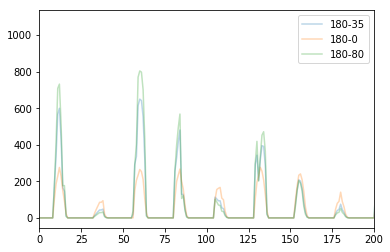

In [34]:
newirr1=irr1/max(irr1)
newirr2=irr2/max(irr2)
newirr3=irr3/max(irr3)

plt.plot(irr1, alpha=0.3,label="180-35");
plt.plot(irr2, alpha=0.3,label="180-0");
plt.plot(irr5, alpha=0.3,label="180-70");
plt.xlim([0,200])
plt.legend()



111242.98073462928
90020.47733071244
118911.14618264529
120394.44685408784
119020.86506923949
114849.49066453244
108018.24823158255


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


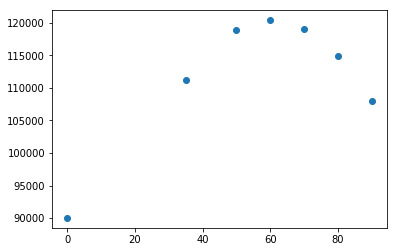

In [38]:
print(irr1[0:24*30*2].sum())
print(irr2[0:24*30*2].sum())
print(irr3[0:24*30*2].sum())
print(irr4[0:24*30*2].sum())
print(irr5[0:24*30*2].sum())
print(irr6[0:24*30*2].sum())
print(irr7[0:24*30*2].sum())

x_ = [35,0,50,60,70,80,90]
y_ = [ irr1[0:24*30*2].sum(), irr2[0:24*30*2].sum(),irr3[0:24*30*2].sum(),irr4[0:24*30*2].sum(),irr5[0:24*30*2].sum(),irr6[0:24*30*2].sum(),irr7[0:24*30*2].sum()]

plt.scatter(x_,y_)

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


In [15]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals = (108,264.6958364,251.340911,1.163782229,7.311781449,11.44391934,0.438019199,0.235562602,0.202648889)

print(pan_vals)

solver_settings={
                    'name': 'gurobi',
                    'options':None
                    }
# ,
#                     'solver_path':'C:\Program Files\glpk\w64\glpsol.exe',
#                     'options': ['--mipgap 0.01']
# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=1.5,
                           solver_settings=solver_settings)

(108, 264.6958364, 251.340911, 1.163782229, 7.311781449, 11.44391934, 0.438019199, 0.235562602, 0.202648889)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63
{'name': 'gurobi', 'options': None}
Found the solver set


ERROR:ga_logger:panel values: (108, 264.6958364, 251.340911, 1.163782229, 7.311781449, 11.44391934, 0.438019199, 0.235562602, 0.202648889)
ERROR:ga_logger:price of the panel 400
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 1.2
                                           and a gcr of 0.438
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 7.682326078414917 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 7.3
                                           and a gcr of 0.236
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 7.470782518386841 sec
ERROR:root:Finished Generation of 

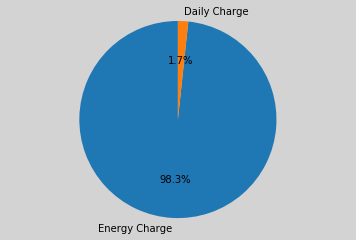

Total roof area of the  building: 599 m2
Total roof area used 0 m2
Percentage: 0.0%


In [16]:
my_model.eval_model(pan_vals,400,pvpanel)

In [17]:
import pulp
from pulp.tests import run_tests
run_tests.pulpTestAll()

Solver <class 'pulp.apis.coin_api.PULP_CBC_CMD'> available
Solver <class 'pulp.apis.cplex_api.CPLEX_DLL'> unavailable
Solver <class 'pulp.apis.cplex_api.CPLEX_CMD'> available
Solver <class 'pulp.apis.cplex_api.CPLEX_PY'> unavailable
Solver <class 'pulp.apis.coin_api.COIN_CMD'> available
Solver <class 'pulp.apis.coin_api.COINMP_DLL'> unavailable
Solver <class 'pulp.apis.glpk_api.GLPK_CMD'> available
Solver <class 'pulp.apis.xpress_api.XPRESS'> unavailable
Solver <class 'pulp.apis.gurobi_api.GUROBI'> unavailable
Solver <class 'pulp.apis.gurobi_api.GUROBI_CMD'> available
Solver <class 'pulp.apis.glpk_api.PYGLPK'> unavailable
Solver <class 'pulp.apis.coin_api.YAPOSIB'> unavailable
Solver <class 'pulp.apis.choco_api.PULP_CHOCO_CMD'> available
Solver <class 'pulp.apis.mipcl_api.MIPCL_CMD'> unavailable
Solver <class 'pulp.apis.mosek_api.MOSEK'> unavailable
	 Testing zero subtraction
.	 Testing inconsistant lp solution
DEBUG:pulp.apis.core:C:\ProgramData\Anaconda3\lib\site-packages\pulp\apis\.

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
import pulp
from pulp.tests import test_pulp
test=test_pulp.PuLPTest('test_pulp_001', 'CHOCO_CMD')
test.test_pulp_001()

AttributeError: 'str' object has no attribute 'copy'